<a href="https://colab.research.google.com/github/jposyluzny/ENEL645/blob/main/Lectures/Week%205/AutoEncoderMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-encoders - MNIST

The learning goals of this tutorial are:
    - Learn how to define fully-connected and convolutional auto-encoders;
    - Learn how an auto-encoder can be used for denoising
    
Additional material: [Keras auto-encoders](https://blog.keras.io/building-autoencoders-in-keras.html)

In [14]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Load dataset, explore it  and split it into train, validation and test sets

- [Load MNIST Keras](https://keras.io/api/datasets/mnist/#load_data-function)

In [15]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


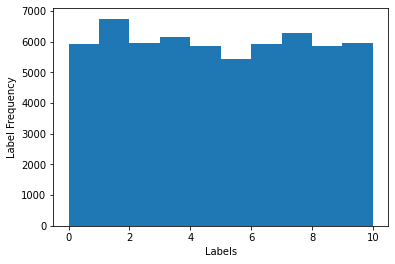

In [16]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

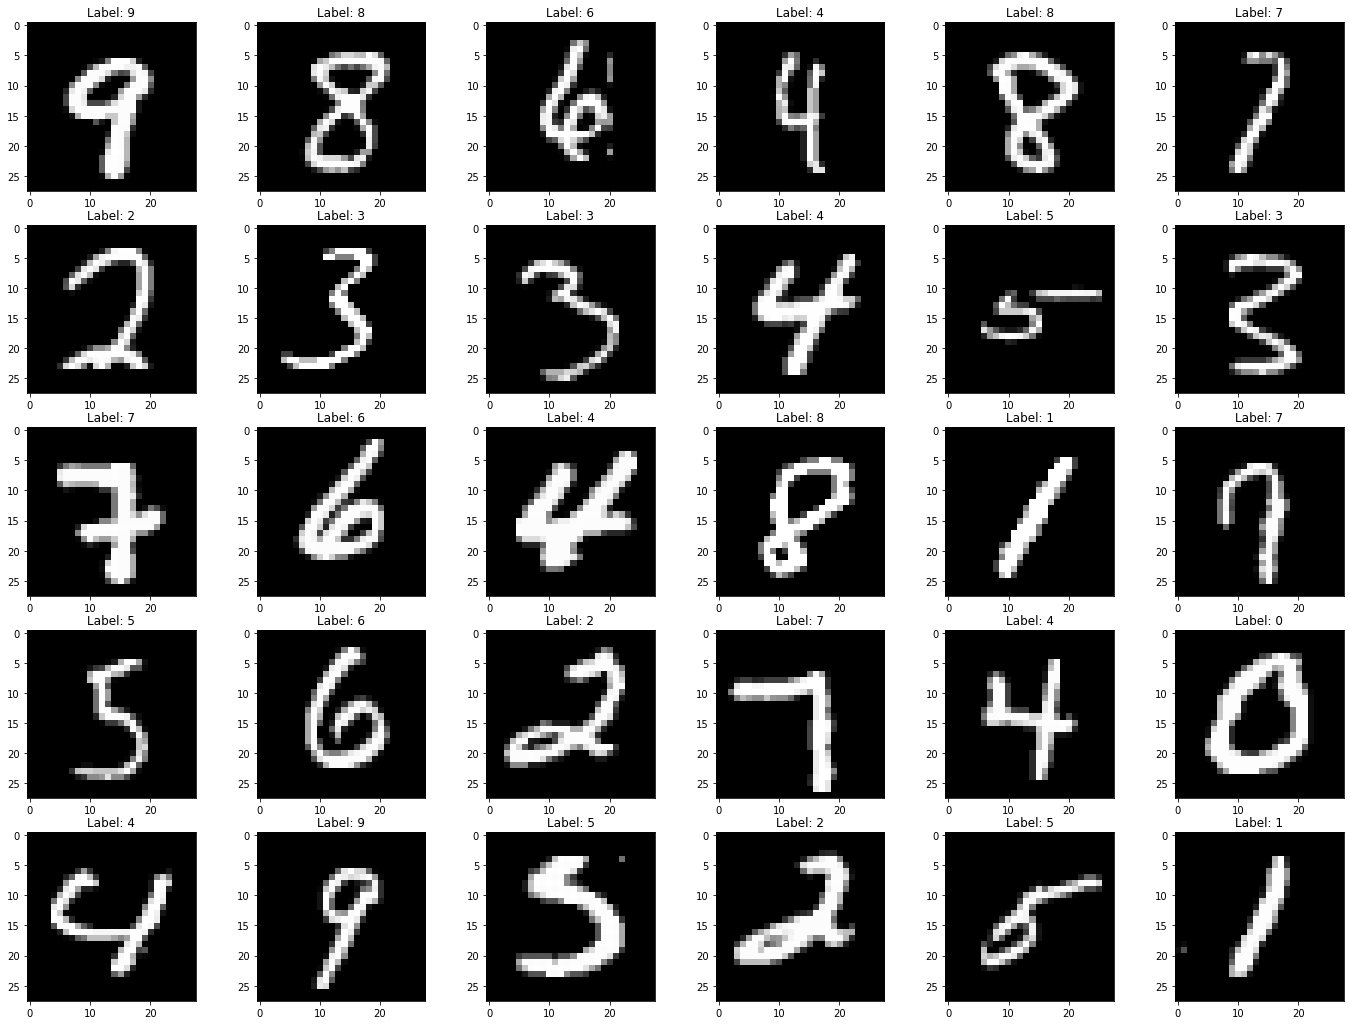

In [17]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [18]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [19]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.357974801587304 78.6152624300752
0 255 33.199761394557825 78.4238783452143


## 2. Data Scaling 

In [20]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [30]:
model_name = "autoencoder_mnist_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 4. Define your model, cost function, optimizer, learning rate

In [38]:
def auto_encoder_fc(ishape = (28,28), ndim = 2, lr = 1e-4):
  input_img = tf.keras.layers.Input(shape=ishape)
  input_flat = tf.keras.layers.Flatten()(input_img) # represents the image as a vector
  d1 = tf.keras.layers.Dense(500, activation='relu')(input_flat)
  d2 = tf.keras.layers.Dense(250, activation='relu')(d1)
  d3 = tf.keras.layers.Dense(ndim, activation='relu')(d2) # this will project the data to a 2-dimensional space
  encoder = tf.keras.models.Model(inputs=input_img, outputs = d3) # output is d3, which is the latent representation
  input_decoder = tf.keras.layers.Input(shape=(ndim)) # this input_decoder has the same shape as the latent representation
  d4 = tf.keras.layers.Dense(250, activation='relu')(input_decoder)
  d5 = tf.keras.layers.Dense(500, activation='relu')(d4)
  d6 = tf.keras.layers.Dense(ishape[0]*ishape[1], activation='linear')(d5)
  out = tf.keras.layers.Reshape(ishape)(d6)
  decoder = tf.keras.models.Model(inputs=input_decoder, outputs=out)
  autoencoder = tf.keras.models.Model(inputs=input_img, outputs=decoder(encoder(input_img)))
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
  return encoder, decoder, autoencoder

# NOTE ON THE SHAPES OF THE BELOW LAYERS:
# input is shape 28x28
# after c1, shape is 14x14
# after c2, shape is 7x7
# after c3, shape is 4x4, number of channels is the number of filters in c3, so 4x4x128 goes into d2

def auto_encoder_cnn(ishape=(28,28,1), ndim=2, lr=1e-4): # we include 1 in shape here because we need to include the number of channels for cnn. it's 1 here, because they're grayscale
  input_img = tf.keras.layers.Input(shape=ishape)
  c1 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', strides = (2,2), padding='same')(input_img) # 32 for 32 filters, (3,3) for a 3x3 kernel
  c2 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = (2,2), padding='same')(c1)
  c3 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = (2,2), padding='same')(c2)
  flat = tf.keras.layers.Flatten()(c3)
  d1 = tf.keras.layers.Dense(ndim)(flat) # project data into 2 dimensional space, this is the latent space
  encoder = tf.keras.models.Model(inputs=input_img, outputs=d1)
  input_decoder = tf.keras.layers.Input(shape = (ndim))
  d2 = tf.keras.layers.Dense(4*4*128)(input_decoder) # we want to have a dense layer that maps from the latent space to an image. size should be the same size as the flat layer, which is 4x4x128
  reshaped_img = tf.keras.layers.Reshape((4,4,128))(d2) # outputs a 4x4 image
  up1 = tf.keras.layers.UpSampling2D((2,2))(reshaped_img) # upsample the data now, 2x2 means a upsampling by a factor of 2 in each image, 4x4 image becomes 8x8
  c4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(up1) # not changing image size here
  up2 = tf.keras.layers.UpSampling2D((2,2))(c4) # changes 8x8 image to 16x16
  c5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(up2) # we don't do the padding here, because if we did, the image size would remain 16x16. now, it will output a 14x14 image
  up3 = tf.keras.layers.UpSampling2D((2,2))(c5) # changes 14x14 image to 28x28
  c6 = tf.keras.layers.Conv2D(1, (3,3), activation = 'relu', padding='same')(up3) # final output is just an image with 1 channel, because it is grayscale
  decoder = tf.keras.models.Model(inputs = input_decoder, outputs = c6)
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
  autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss= 'mse')
  return encoder, decoder, autoencoder

In [45]:
encoder,decoder,autoencoder = auto_encoder_cnn(ndim=10)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                20490     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
____________________________________________________

## 6. Train your model

In [46]:
autoencoder.fit(X_train,X_train,batch_size = 64, epochs = 10, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,X_val)) # for this, our target is the same as our input, so that's why X_train is called twice

Epoch 1/10
704/704 [==============================] - 4s 5ms/step - loss: 0.0635 - val_loss: 0.0285
Epoch 2/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0271 - val_loss: 0.0238
Epoch 3/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0233 - val_loss: 0.0217
Epoch 4/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0215 - val_loss: 0.0206
Epoch 5/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 6/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 7/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0191 - val_loss: 0.0186
Epoch 8/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 9/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 10/10
704/704 [==============================] - 3s 5ms/step - loss: 0.0176 - val_loss: 0.0175

In [47]:
autoencoder.load_weights(model_name)
metrics = autoencoder.evaluate(X_test,X_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0172


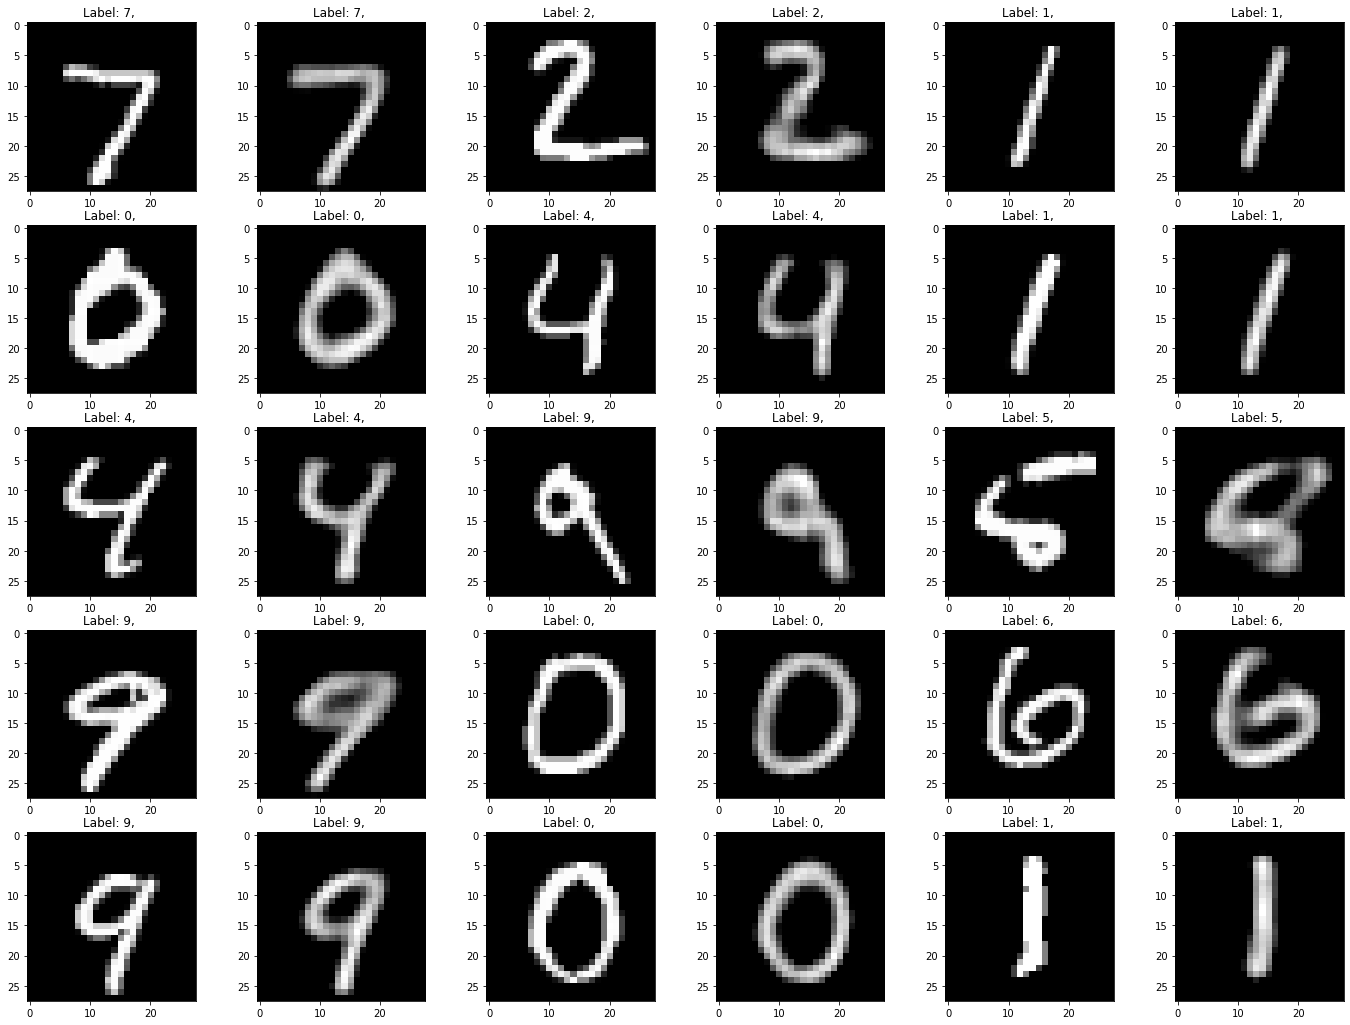

In [48]:
Xpred = autoencoder.predict(X_test)[:,:,:,0] # this index argument at the end needs to be here for the CNN. when the prediction returns something that has 1 channel,
# matplotlib doesn't understand the one channel, the index argument is needed. the index argument doesn't need to be present for fully connected network



plt.figure(figsize = (24,18))
for (ii) in range(15):
    plt.subplot(5,6,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.title("Label: %d, " %(Y_test[ii]))
    plt.subplot(5,6,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    
    plt.title("Label: %d, " %(Y_test[ii]))
plt.show()

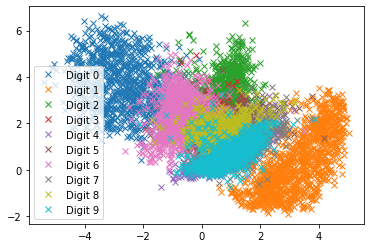

In [44]:
# Only works for ndim = 2
Xencoded = encoder.predict(X_test)
plt.figure()
for ii in range(10):
    plt.plot(Xencoded[Y_test == ii,0],Xencoded[Y_test == ii,1],'x', label = "Digit %s" %(str(ii)))
plt.legend()
plt.show()

## (Bonus) Denoising auto-encoder

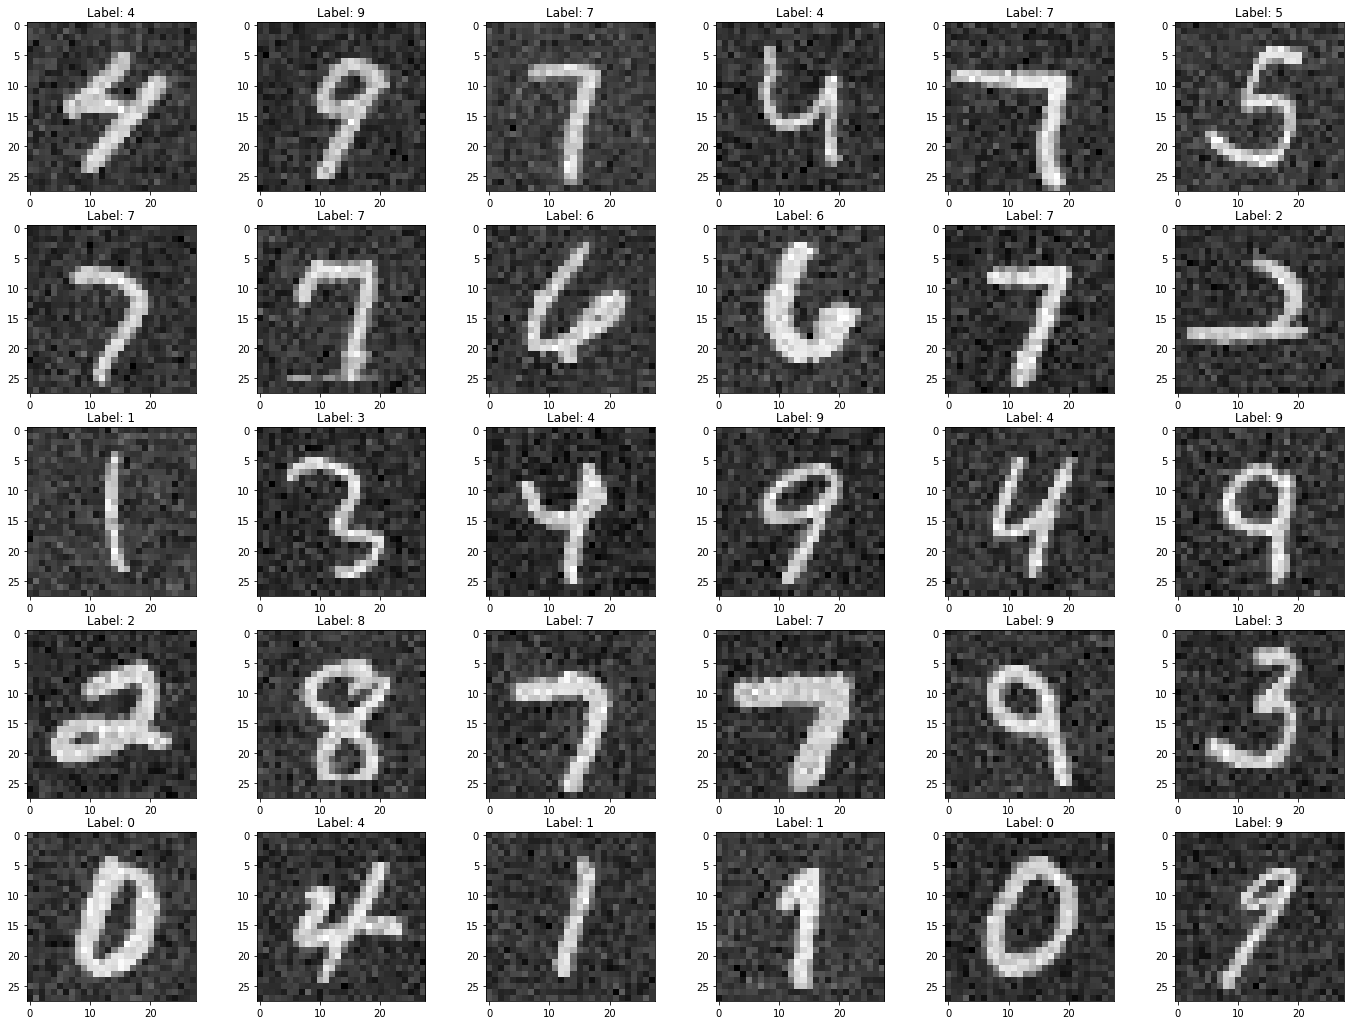

In [49]:
# Adding noise
mu = 0
sigma = 0.1
X_train_noisy = X_train + np.random.normal(mu,sigma,X_train.shape)
X_val_noisy = X_val + np.random.normal(mu,sigma,X_val.shape)
X_test_noisy = X_test + np.random.normal(mu,sigma,X_test.shape)


# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_train_noisy.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train_noisy[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [ ]:
model_name = "autoencoder_mnist_cnn_denoiser.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
encoder,decoder,autoencoder = auto_encoder_cnn(ndim = 10)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())